In [1]:
import os
import random

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

from functools import partial

import time
import scipy.stats as stats
import seaborn as sns
import arviz as az
import collections

#import constants

#from tqdm import tqdm
from tqdm.auto import tqdm
tqdm.pandas()

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

pd.set_option('display.max_columns', None)

/opt/anaconda3/envs/Boda_2/lib/python3.7/site-packages/tqdm/std.py:702: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
class constants():
    def __init__(self):
        self.STANDARD_NT = ['A','C','G','T']
        self.DNA_COMPLEMENTS = {'A':'T', 'G':'C', 'T':'A', 'C':'G'}
constants = constants()

class utils():   
    @staticmethod
    def pad_pssm(row, pad_len=24, column_name='pssm'):
        padded_pssm = np.zeros((4, pad_len))
        padded_pssm[:, 0:row['length']] = row[column_name]
        return padded_pssm

    @staticmethod
    def pad_seq_tensor(seq_tensor, pad_len=217, dim=-1):
        assert seq_tensor.shape[dim] <= pad_len
        padded_tensor = torch.zeros((4, pad_len))
        padded_tensor[:, 0:seq_tensor.shape[dim]] = seq_tensor
        return padded_tensor
        
    @staticmethod
    def dna2tensor(sequence_str, vocab_list=constants.STANDARD_NT):
        seq_tensor = np.zeros((len(vocab_list), len(sequence_str)))
        for letterIdx, letter in enumerate(sequence_str):
            seq_tensor[vocab_list.index(letter), letterIdx] = 1
        seq_tensor = torch.Tensor(seq_tensor)
        return seq_tensor

    @staticmethod
    def row_dna2tensor(row, in_column_name='padded_seq' , vocab=['A', 'C', 'G', 'T']):
        sequence_str = row[in_column_name]
        seq_idxs = torch.tensor([vocab.index(letter) for letter in sequence_str])
        sequence_tensor = F.one_hot(seq_idxs, num_classes=4).transpose(1,0)
        return sequence_tensor.type(torch.float32)
    
    @staticmethod
    def append_zero_tensor(row, in_column_name='seq_tensor', target_len=217):
        seq__tensor = row[in_column_name]
        num_zeros = target_len - seq__tensor.shape[-1]
        zeros = torch.zeros((4, num_zeros))
        padded_seq = torch.cat( (seq__tensor, zeros), dim=-1 )
        return padded_seq
    
    @staticmethod
    def reverse_complement_onehot(x, nt_order=constants.STANDARD_NT, 
                              complements=constants.DNA_COMPLEMENTS):
        comp_alphabet = [ complements[nt] for nt in nt_order ]
        permutation = [ nt_order.index(nt) for nt in comp_alphabet ]   
        return torch.flip(x[..., permutation, :], dims=[-1])

    @staticmethod
    def append_zero_tensor(row, in_column_name='seq_tensor', target_len=217):
        seq__tensor = row[in_column_name]
        num_zeros = target_len - seq__tensor.shape[-1]
        zeros = torch.zeros((4, num_zeros))
        padded_seq = torch.cat( (seq__tensor, zeros), dim=-1 )
        return padded_seq

def counts_to_ppm(in_tensor):
    motif = in_tensor.div( in_tensor.sum(0) )
    return motif

def ppm_to_pwm(in_tensor,bkg=[0.25,0.25,0.25,0.25]):
    motif = in_tensor.div(torch.tensor(bkg).unsqueeze(1)).log2()
    return motif

def ppm_to_U(in_tensor):
    return (in_tensor.log2() * in_tensor).sum(0).mul(-1.)

def ppm_to_IC(in_tensor):
    return in_tensor * ppm_to_U( in_tensor ).mul(-1.).add(2.)

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def single_scatterplot(data_df, x_axis, y_axis, color_axis, fig_size=(15,8), dot_size=0.5, title='',
                       dot_alpha=0.5, style='seaborn-whitegrid', colormap='winter',
                       x_label='Experimental', y_label='Predicted', color_label='l2fc SE', title_font_size=18,
                       title_font_weight='medium', axis_font_size=16):
    with plt.style.context(style):
        fig, ax = plt.subplots()    
        data_df.plot(kind='scatter', x=x_axis, y=y_axis, figsize=fig_size, c=color_axis, ax=ax,
                        alpha=dot_alpha, s=dot_size, colormap=colormap)
        plt.xlabel(x_label, fontsize=axis_font_size)
        plt.ylabel(y_label, fontsize=axis_font_size)

        f = plt.gcf()
        cax = f.get_axes()[1]
        cax.set_ylabel(color_label, fontsize=axis_font_size)

        x_min, y_min = data_df[[x_axis, y_axis]].min().to_numpy() 
        x_max, y_max = data_df[[x_axis, y_axis]].max().to_numpy()
        min_point, max_point = min(x_min, y_min), max(x_max, y_max)
        plt.plot((min_point,max_point), (min_point,max_point), color='black', linestyle='--', alpha=0.5)

        Pearson = round(data_df[[x_axis, y_axis]].corr(method='pearson')[x_axis][1], 2)
        Spearman = round(data_df[[x_axis, y_axis]].corr(method='spearman')[x_axis][1], 2)

        #title = f'{title}  |  Pearson={Pearson}  Spearman={Spearman}'
        title = f'{title}  |  Pearson {Pearson}'
        ax.set_title(title, fontdict={'fontsize': title_font_size, 'fontweight': title_font_weight}, pad=15)
        
        ax.tick_params(axis='both', which='major', labelsize=axis_font_size)

def string_to_numpy(text, dtype=None):
    """
    Convert text into 1D or 2D arrays using np.matrix().
    The result is returned as an np.ndarray.
    """
    import re
    text = text.strip()
    # Using a regexp, decide whether the array is flat or not.
    # The following matches either: "[1 2 3]" or "1 2 3"
    is_flat = bool(re.match(r"^(\[[^\[].+[^\]]\]|[^\[].+[^\]])$",
                            text, flags=re.S))
    # Replace newline characters with semicolons.
    text = text.replace("]\n", "];")
    # Prepare the result.
    result = np.asarray(np.matrix(text, dtype=dtype))
    return result.flatten() if is_flat else result

def str2tensor(array_string):
    return torch.tensor([float(item) for item in array_string.lstrip('[[ ').rstrip(' ]]').split(' ') if item != ''])

def ppm_to_IC_alt(in_tensor):
    U = (in_tensor.log2() * in_tensor).sum(dim=1).mul(-1.)
    return in_tensor * U[:, None, :].mul(-1.).add(2.)

def tensor_to_pandas(in_tensor, tokens=constants.STANDARD_NT, colors=['green','orange','red','blue']):
    data = []
    my_array = in_tensor.cpu().numpy()
    for nt, score_vec,color in zip(tokens,[ sub_a for sub_a in my_array ],colors):
         _ = [ data.append([j,nt,score,color]) for j,score in enumerate(score_vec) ]
    return pd.DataFrame(data=data,columns=['site', 'letter', 'height','color'])

def matrix_to_dms(in_tensor, ax=None, y_max=2, fontaspect=.55, widthscale=0.8,
                  axisfontscale=0.6, heightscale=0.8, colors=['green','blue','orange','red']):
    motif = tensor_to_pandas(in_tensor, colors=colors)
    fig, ax = dmslogo.draw_logo(data=motif,
                                x_col='site',
                                letter_col='letter',
                                letter_height_col='height',
                                color_col='color',
                                ax=ax,
                                fixed_ymax=y_max,
                                fontaspect=fontaspect,
                                widthscale=widthscale,
                                axisfontscale=axisfontscale,
                                heightscale=heightscale)
    return fig, ax

def double_pad_seq_tensor(seq_tensor, pad_len=25):
    total_out_len = 2*pad_len + seq_tensor.shape[-1] - 2
    padded_tensor = torch.zeros((4, total_out_len))
    tensor_start = pad_len-1
    tensor_stop = tensor_start + seq_tensor.shape[-1]
    padded_tensor[..., tensor_start:tensor_stop] = seq_tensor
    return padded_tensor

def double_pad_seq_tensor_2(seq_tensor, pad_len=15):
    total_out_len = 2*pad_len + seq_tensor.shape[-1] - 2
    padded_tensor = torch.zeros((seq_tensor.shape[0], seq_tensor.shape[1], total_out_len))
    tensor_start = pad_len-1
    tensor_stop = tensor_start + seq_tensor.shape[-1]
    padded_tensor[..., tensor_start:tensor_stop] = seq_tensor
    return padded_tensor

def align_to_alphabet(in_tensor, in_alphabet=['A','C','G','T'], out_alphabet=constants.STANDARD_NT):
    permuted_idxs = []
    for nt in out_alphabet:
        permuted_idxs.append(in_alphabet.index(nt))
    permutation_idxs = torch.LongTensor(permuted_idxs)
    out_tensor = in_tensor[permutation_idxs, :]
    return out_tensor

def reverse_complement(in_tensor, alphabet=constants.STANDARD_NT):
    rc_dict = {'A':'T', 'G':'C', 'T':'A', 'C':'G'}
    reversed_alphabet = [rc_dict[nt] for nt in alphabet]
    out_tensor = align_to_alphabet(in_tensor, in_alphabet=alphabet,  out_alphabet=reversed_alphabet)
    out_tensor = torch.flip(out_tensor, dims=[1])
    return out_tensor

def show_streme_motifs(parsed_output, num_motifs=None):
    motif_dict = parsed_output['motif_results']
    results_alphabet = parsed_output['meta_data']['alphabet']
    if not num_motifs:
        Range = len(motif_dict)
    else:
        Range = num_motifs
    for motif_idx in range(Range):
        motif_ppm = torch.tensor((motif_dict[motif_idx]['ppm']))
        motif_ppm = align_to_alphabet(motif_ppm, in_alphabet=results_alphabet)
        motif_ppm_rc = reverse_complement(motif_ppm)
        print(motif_dict[motif_idx]['summary'])
        matrix_to_dms(ppm_to_IC(motif_ppm), y_max=2)
        plt.show()
        matrix_to_dms(ppm_to_IC(motif_ppm_rc), y_max=2)
        plt.show()

### Load TFs, boda sequences, Streme motifs

In [3]:
file_path = '/Users/castrr/Dropbox (JAX)/Datasets/TF_motifs/HOCOMOCO_and_JASPAR_processed_TF_info.txt'

tf_df = pd.read_csv(file_path, sep=' ', low_memory=False)

df_array_columns = ['pfm', 'pwm', 'pwm_rc', 'pssm', 'pssm_rc', 'icm', 'icm_rc', 'padded_pssm', 'padded_pssm_rc']
for df_array_column in tqdm(df_array_columns):
    tf_df[df_array_column] = tf_df.apply(lambda x: string_to_numpy(x[df_array_column]), axis=1)

  0%|          | 0/9 [00:00<?, ?it/s]

In [4]:
file_path = '/Users/castrr/Dropbox (JAX)/Datasets/BODA2/motif_penalization_stremes/BODA_fsp_penalization_893131_STREME_processed_TF_info.txt'

streme_df = pd.read_csv(file_path, sep=' ', low_memory=False)

df_array_columns = ['pfm', 'pwm', 'pwm_rc', 'pssm', 'pssm_rc', 'icm', 'icm_rc', 'padded_pssm', 'padded_pssm_rc']
for df_array_column in tqdm(df_array_columns):
    streme_df[df_array_column] = streme_df.apply(lambda x: string_to_numpy(x[df_array_column]), axis=1)
    
streme_df['streme_idx'] = [int(name.split('-')[0]) for name in streme_df['name'].tolist()]
streme_df = streme_df.sort_values('streme_idx').reset_index(drop=True)

  0%|          | 0/9 [00:00<?, ?it/s]

In [5]:
boda2_df = pd.read_csv('/Users/castrr/Dropbox (JAX)/Datasets/BODA2/BODA2_MPRA_results_pred_contributions_v3.txt', sep=" ", low_memory=False)
no_controls_df = boda2_df[boda2_df['method'].notnull()].copy().reset_index(drop=True)

### Select cell type and method

In [6]:
target_cell = 'k562'
method = 'fsp'            #'fsp', 'al', 'sa'

quality_filter = (no_controls_df[['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']].max(axis=1) <= 1.0) 
data_df = no_controls_df[quality_filter].copy().reset_index(drop=True)

data_df = data_df[(data_df['method'] == method) & (data_df['target_cell'] == target_cell)].reset_index(drop=True)

track_info = [a[1] for a in data_df['ID'].str.split('__').tolist() ]
data_df['penalty_track'] = track_info

data_df['penalty_track'].dropna().unique()

array(['323391', '477844', '730114', '619474', '893131'], dtype=object)

In [7]:
streme_dicts = {}
for root, dirs, files in os.walk('/Users/castrr/Dropbox (JAX)/Datasets/BODA2/fsp_streme_dicts'):
    for file_path in files:
        if target_cell in file_path:
            _, method, cell_type, track_ID, random_tag, round = file_path.split('__')
            if round != 'round_0':
                #track_info = ('__').join([track_ID, random_tag, round.rstrip('.pt')])
                track_info = random_tag + '__' + round.rstrip('.pt')
                print(file_path)
                streme_dicts[track_info] = torch.load(root + '/' + file_path)

streme_penalty__fsp__k562__20211212_085225__619474__round_2.pt
streme_penalty__fsp__k562__20211212_024754__730114__round_5.pt
streme_penalty__fsp__k562__20211212_092818__893131__round_3.pt
streme_penalty__fsp__k562__20211212_024754__730114__round_1.pt
streme_penalty__fsp__k562__20211212_085225__619474__round_3.pt
streme_penalty__fsp__k562__20211212_024754__730114__round_4.pt
streme_penalty__fsp__k562__20211212_092818__893131__round_2.pt
streme_penalty__fsp__k562__20211212_022207__477844__round_5.pt
streme_penalty__fsp__k562__20211212_022207__477844__round_1.pt
streme_penalty__fsp__k562__20211212_022207__477844__round_4.pt
streme_penalty__fsp__k562__20211212_022207__477844__round_3.pt
streme_penalty__fsp__k562__20211212_022207__477844__round_2.pt
streme_penalty__fsp__k562__20211212_024754__730114__round_3.pt
streme_penalty__fsp__k562__20211212_085225__619474__round_4.pt
streme_penalty__fsp__k562__20211212_092818__893131__round_5.pt
streme_penalty__fsp__k562__20211212_092818__893131__rou

### Score Streme motifs

In [8]:
temp_filters = torch.Tensor(np.concatenate([np.stack(streme_df['padded_pssm']), np.stack(streme_df['padded_pssm_rc'])], axis=0))
score_trhesholds = torch.Tensor(np.concatenate([streme_df['threshold_patser'], streme_df['threshold_patser']]))

In [9]:
track_id = '893131'

track_df = data_df[(data_df['penalty_track'] == track_id)].reset_index()
track_onehot_sequences = torch.stack([double_pad_seq_tensor(utils.dna2tensor(seq), pad_len=temp_filters.shape[-1]) \
                                          for seq in track_df['sequence'].tolist()]).type(torch.float32)

track_scores = F.conv1d(track_onehot_sequences, temp_filters)

motif_frequencies = (track_scores > score_trhesholds[None, :, None]).sum(dim=-1)
motif_frequencies = motif_frequencies[:, 0:len(streme_df)] + motif_frequencies[:, len(streme_df):]

scores_above = track_scores * (track_scores > score_trhesholds[None, :, None])
scores_above = scores_above.sum(dim=-1)
scores_above = scores_above[:, 0:len(streme_df)] + scores_above[:, len(streme_df):]

track_df[streme_df['name'].tolist()] = motif_frequencies.numpy()

In [10]:
motif_columns = streme_df['name'].tolist()

binary_string_vectors = [str(1*(track_df[motif_columns] > 0).to_numpy()[row, :]) for row in range(len(track_df))]
track_df['binary_string_vector'] = binary_string_vectors
all_x_ticks = sorted(set(binary_string_vectors))

In [11]:
rounds_num_seqs = [len(track_df[track_df['round'] == i]) for i in range(6)]

temp_df = track_df[track_df['OverMax'] >= 0]
df_plot = temp_df.groupby(['round', 'binary_string_vector']).size().reset_index().pivot(columns='round', index='binary_string_vector', values=0)
df_plot = df_plot / rounds_num_seqs
df_plot.fillna(0, inplace=True)

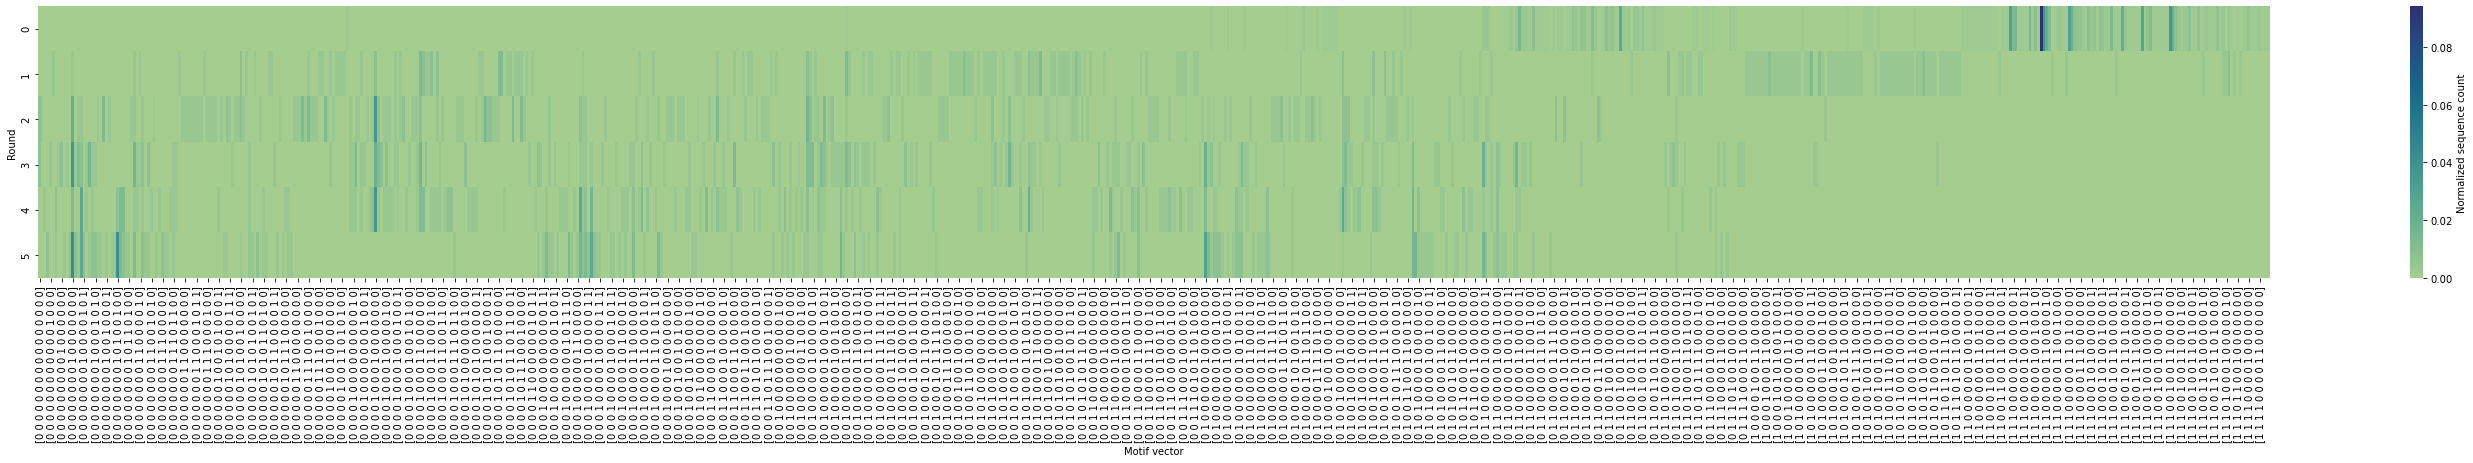

In [12]:
plt.figure(figsize=(50,5)) 
sns.heatmap(df_plot.T, cmap='crest', cbar_kws={'label': 'Normalized sequence count'})
plt.xlabel('Motif vector')
plt.ylabel('Round')
plt.show()

In [18]:
#--- For Sager ---

# out_df = track_df[['ID', 'round', 'K562_signal',
#        'HepG2_signal', 'SKNSH_signal', 'K562_pred_aggreg', 'HepG2_pred_aggreg',
#        'SKNSH_pred_aggreg', 'OverMax', '1-ACAGCTGTCAAVYGY', '2-AGATAAGG', '3-DVCABVTGBH',
#        '4-HTTCYWRGAAD', '5-GCCACACCC', '6-GCCGTCGAAG', '7-CSCGCCAAA',
#        '8-ARAGCGCGCGCTA', '9-CCTTATCG', '10-AGGTGTGA', '11-ACTCAGCACTTTTT',
#        '12-AAGGCGSGAAAA', '13-CGCTATCTCA', '14-MTGASTCAK', '15-GCTCCTCGAGG',
#        '16-CTCCAGACGTT']]

# out_df = track_df[['ID', 'round', '1-ACAGCTGTCAAVYGY', '2-AGATAAGG', '3-DVCABVTGBH',
#        '4-HTTCYWRGAAD', '5-GCCACACCC', '6-GCCGTCGAAG', '7-CSCGCCAAA',
#        '8-ARAGCGCGCGCTA', '9-CCTTATCG', '10-AGGTGTGA', '11-ACTCAGCACTTTTT',
#        '12-AAGGCGSGAAAA', '13-CGCTATCTCA', '14-MTGASTCAK', '15-GCTCCTCGAGG',
#        '16-CTCCAGACGTT']]

# out_df.to_csv('motif_occupancy_fsp_penalization_k562.txt', sep=' ', index=None)

In [34]:
track_df.sort_values(by='round').reset_index(drop=True)

,index,ID,sequence,project,method,round,K562_signal,HepG2_signal,SKNSH_signal,K562_lfcSE,HepG2_lfcSE,SKNSH_lfcSE,K562_ctrl_mean,HepG2_ctrl_mean,SKNSH_ctrl_mean,K562_exp_mean,HepG2_exp_mean,SKNSH_exp_mean,K562_pred,HepG2_pred,SKNSH_pred,K562_pred_aggreg,HepG2_pred_aggreg,SKNSH_pred_aggreg,pred_max_cell,signal_max_cell,target_cell,target_cell_lfc,max_non_target_cell,max_non_target_lfc,min_non_target_cell,min_non_target_lfc,mean_non_target_lfc,OverMean,OverMax,contrib_K562,contrib_HepG2,contrib_SKNSH,penalty_track,1-ACAGCTGTCAAVYGY,2-AGATAAGG,3-DVCABVTGBH,4-HTTCYWRGAAD,5-GCCACACCC,6-GCCGTCGAAG,7-CSCGCCAAA,8-ARAGCGCGCGCTA,9-CCTTATCG,10-AGGTGTGA,11-ACTCAGCACTTTTT,12-AAGGCGSGAAAA,13-CGCTATCTCA,14-MTGASTCAK,15-GCTCCTCGAGG,16-CTCCAGACGTT,binary_string_vector
0,6869,20211212_92818__893131__0::fsp__k562__0,GCTGTCAATAGACGTGCGCGCAGCTGTCCACACGCGGGCGAGCCTT...,BODA:k562,fsp,0,4.791016,-0.985970,-0.960359,0.387067,0.374636,0.276942,629.973930,629.973930,629.973930,17442.765247,318.080538,323.789631,6.193643,-1.741304,-1.758882,5.882185,-1.649403,-1.684321,k562,k562,k562,4.791016,sknsh,-0.960359,hepg2,-0.985970,-0.973164,5.764180,5.751375,[-5.64221218e-02 -5.72692938e-02 -8.88955127e-...,[-7.1906015e-02 -7.5108849e-02 -7.8560509e-02 ...,[-5.57445511e-02 -6.77293539e-02 -7.49817565e-...,893131,3,3,8,0,0,0,0,0,3,2,0,0,0,0,0,0,[1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0]
1,7188,20211212_92818__893131__340::fsp__k562__0,GCTGTCAAACGTGCACGGAACAGATAAGAAACTATAAGCAACCGGG...,BODA:k562,fsp,0,5.576491,-0.933429,-1.907606,0.381334,0.360003,0.515282,350.254561,350.254561,350.254561,16714.532332,183.402096,93.413570,6.619493,-1.230130,-1.116895,6.847052,-1.155091,-1.043073,k562,k562,k562,5.576491,hepg2,-0.933429,sknsh,-1.907606,-1.420518,6.997008,6.509920,[-0.007832494 0.010064164 0.0145857055 0....,[-7.4957378e-02 -8.8268124e-02 -1.1449677e-01 ...,[-0.056520276 -0.059079885 -0.0857871 ...,893131,2,3,0,0,0,0,0,0,4,1,0,0,0,0,1,0,[1 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0]
2,7187,20211212_92818__893131__339::fsp__k562__0,CCTCATGCACGTCTGGACGATGCTGATAAGGCGCCTTCCGCGAGTA...,BODA:k562,fsp,0,5.365961,-0.308546,-1.239902,0.383120,0.367292,0.542495,358.585488,358.585488,358.585488,14788.657877,289.517767,151.839643,7.644314,-1.821155,-1.521067,7.029624,-1.592035,-1.357489,k562,k562,k562,5.365961,hepg2,-0.308546,sknsh,-1.239902,-0.774224,6.140184,5.674507,[-6.46215165e-03 -6.78110197e-02 -4.55557019e-...,[-0.046001017 -0.10065504 -0.1032246 ...,[-0.04539291 -0.08048514 -0.06677918 ...,893131,0,3,0,0,0,0,0,0,4,0,0,1,0,0,0,2,[0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 1]
3,7186,20211212_92818__893131__338::fsp__k562__0,GCTCGGCACGTGTGAAACACCTGTCAAGCTCGGGTCGCACTCCAAC...,BODA:k562,fsp,0,4.051550,-1.123201,-1.342602,0.348122,0.427875,0.547328,287.444420,287.444420,287.444420,4767.727580,131.974970,113.244475,6.093593,-1.694935,-1.746266,5.727620,-1.643468,-1.683003,k562,k562,k562,4.051550,hepg2,-1.123201,sknsh,-1.342602,-1.232902,5.284451,5.174751,[-0.047132194 -0.026182858 -0.041950975 -0....,[-0.05826473 -0.06533785 -0.08281547 ...,[-0.0599993 -0.0466707 -0.0566598 ...,893131,3,3,8,0,0,0,0,0,6,2,0,0,0,0,0,0,[1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0]
4,7185,20211212_92818__893131__337::fsp__k562__0,TCGGATAAGCGCTTAAGGAGGAGGTCGCGCACTCTCTGATAGCTGG...,BODA:k562,fsp,0,7.490134,-0.626627,-0.373893,0.385014,0.310282,0.191522,554.488371,554.488371,554.488371,99691.180168,359.104643,427.872764,5.918584,-0.857115,-1.005362,6.204787,-0.723050,-0.895698,k562,k562,k562,7.490134,sknsh,-0.373893,hepg2,-0.626627,-0.500260,7.990394,7.864027,[-1.29380804e-02 -9.09847915e-02 -1.47700027e-...,[-7.06018731e-02 -1.03673249e-01 -4.74247634e-...,[-0.10459975 -0.10779352 -0.018260447 ...,893131,1,2,0,0,0,0,0,0,5,0,0,0,0,0,0,0,[1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1664,8384,20211212_92818__893131__1587::fsp__k562__5,TAGAA

In [71]:
temp_df = track_df.sort_values(by=['round', 'OverMax']).reset_index(drop=True)

round_starts = []
count = 0 
for i in range(5):
    count += len(temp_df[temp_df['round'] == i])
    round_starts.append(count)
round_starts

[468, 704, 943, 1187, 1432]

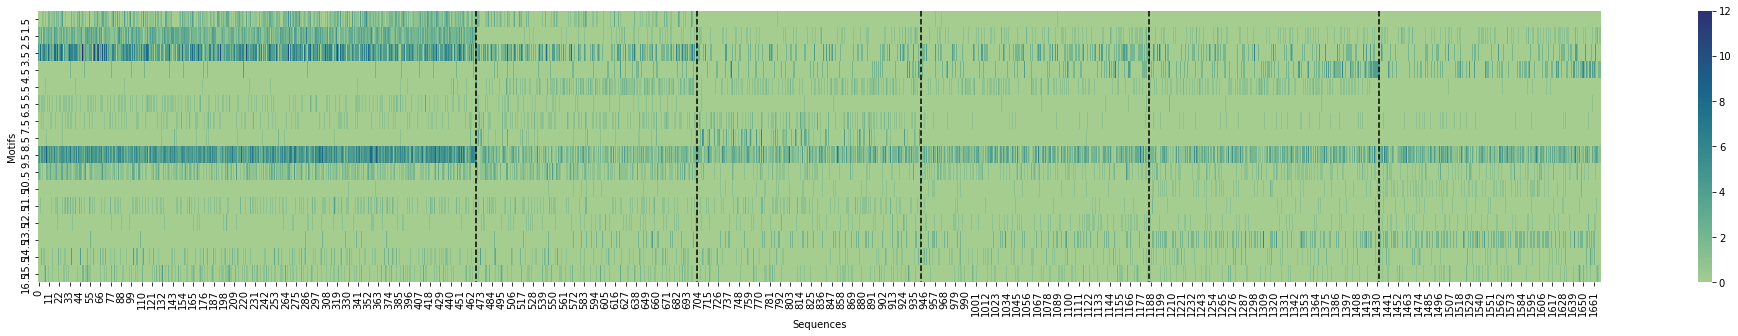

In [122]:
plot_df = temp_df[['1-ACAGCTGTCAAVYGY', '2-AGATAAGG', '3-DVCABVTGBH',
       '4-HTTCYWRGAAD', '5-GCCACACCC', '6-GCCGTCGAAG', '7-CSCGCCAAA',
       '8-ARAGCGCGCGCTA', '9-CCTTATCG', '10-AGGTGTGA', '11-ACTCAGCACTTTTT',
       '12-AAGGCGSGAAAA', '13-CGCTATCTCA', '14-MTGASTCAK', '15-GCTCCTCGAGG',
       '16-CTCCAGACGTT']]
overmax_df = temp_df['OverMax']

plt.figure(figsize=(35,5))
g = sns.heatmap(plot_df.to_numpy().T, cmap='crest')
g.set_yticklabels([str(i+1) for i in g.get_yticks()])
plt.vlines(round_starts, 0, 16, colors='black', linestyles='dashed', linewidth=1.5)
plt.ylabel('Motifs')
plt.xlabel('Sequences')
plt.show()

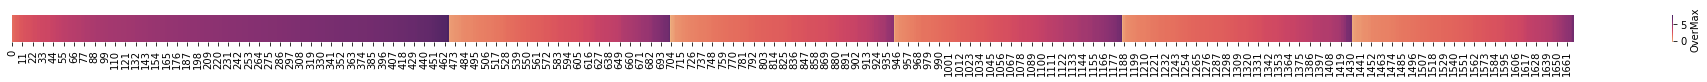

In [80]:
mean_df = pd.DataFrame({'OverMax': overmax_df.tolist()}, index=list(range(len(overmax_df.tolist()))))
plt.figure(figsize=(35,0.5)) 
sns.heatmap(mean_df.T, yticklabels=True, cmap='flare', cbar_kws={'label': 'OverMax'})
plt.yticks([])
plt.show()

In [140]:
scores_above = track_scores * (track_scores > score_trhesholds[None, :, None])
scores_above = scores_above.sum(dim=-1)
scores_above = scores_above[:, 0:len(streme_df)] + scores_above[:, len(streme_df):]
scores_above = scores_above / torch.Tensor(streme_df['max_score'])[None, :]

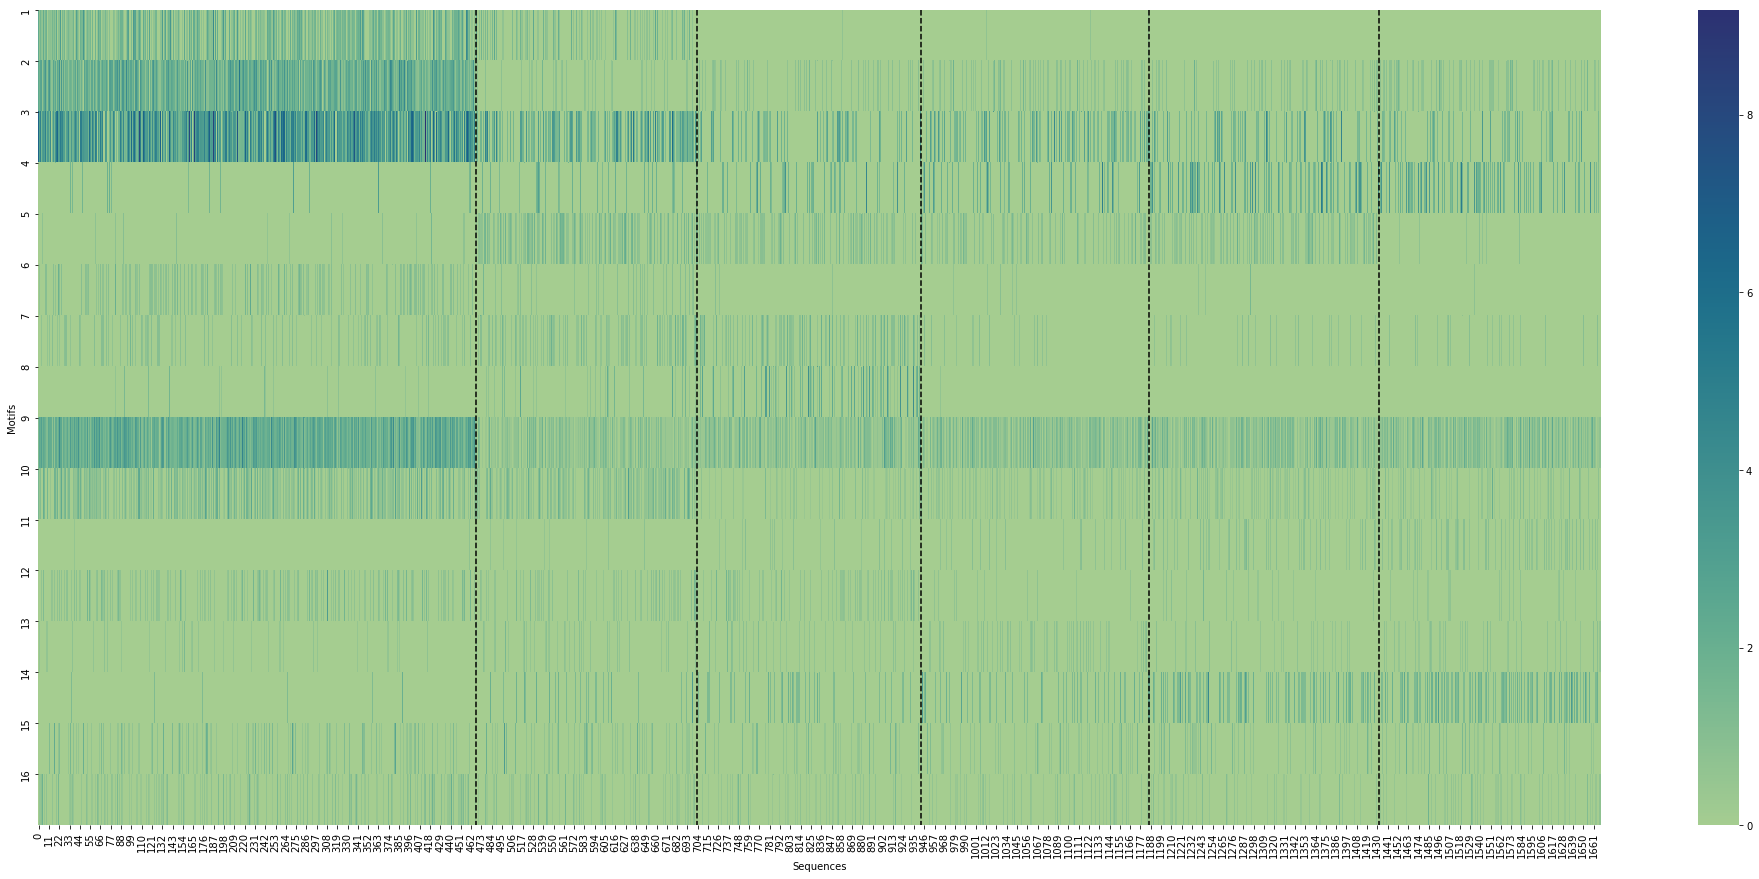

In [220]:
plt.figure(figsize=(35,15))
g = sns.heatmap(scores_above.T, cmap='crest')
g.set_yticks(range(16))
g.set_yticklabels(labels=[str(i+1) for i in g.get_yticks()], va='center')
plt.vlines(round_starts, 0, 16, colors='black', linestyles='dashed', linewidth=1.5)
plt.ylabel('Motifs')
plt.xlabel('Sequences')
plt.show()

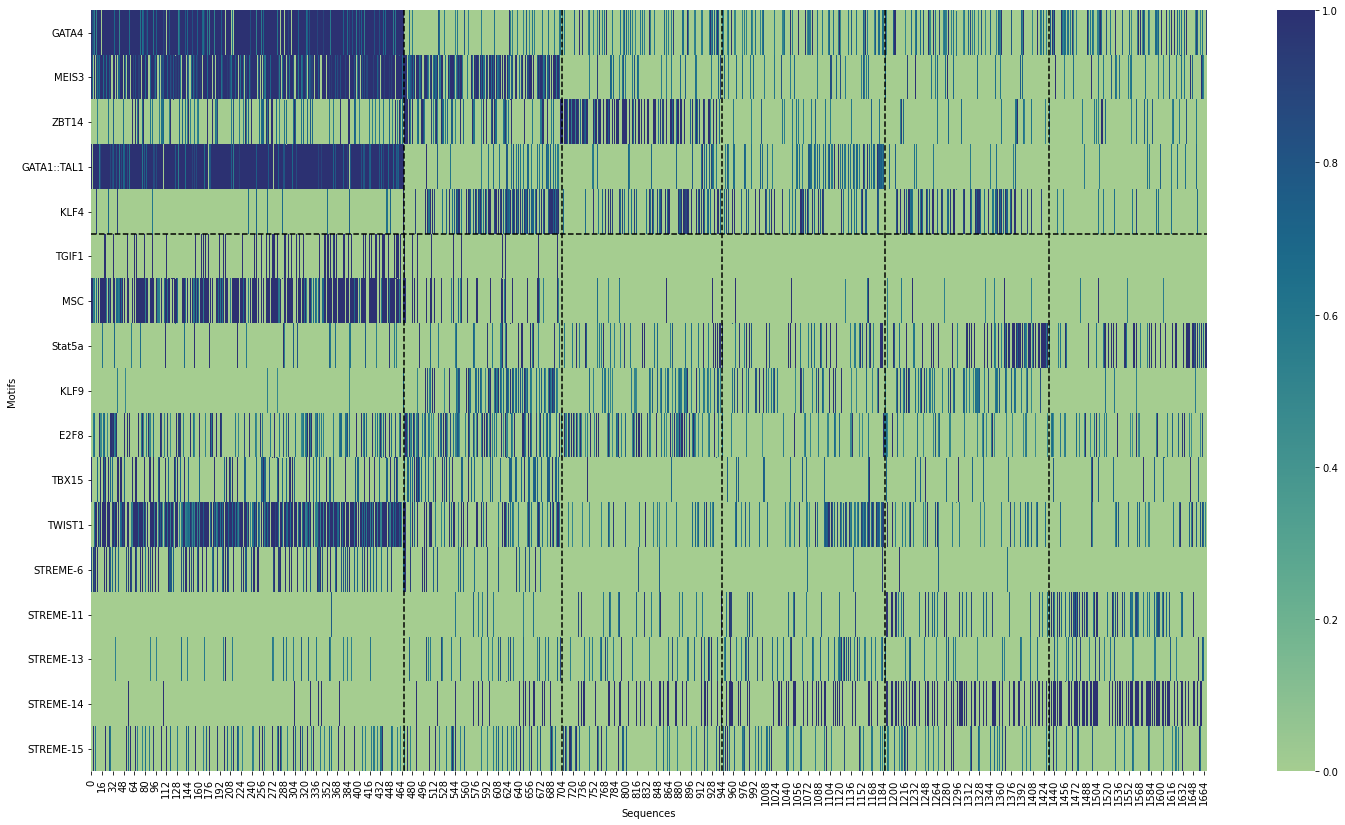

In [337]:
match_motif_ids = ['MA0482.2',
                   'MEIS3_HUMAN.H11MO.0.D',
                   'ZBT14_HUMAN.H11MO.0.C',
                   'MA0140.2',
                   'KLF4_HUMAN.H11MO.0.A',
                  ]
match_motif_ids += ['MA0796.1',
                    'MA0665.1',
                    'MA1624.1',
                    'MA1107.2',
                    'MA0865.2',
                    'MA0803.1',
                    #'MA0800.1',
                    'MA1123.2',
                   ]
extra_streme_idxs = [6, 11, 13, 14, 15]

temp_df = track_df.sort_values(by=['round', 'OverMax']).reset_index(drop=True)
track_onehot_sequences = torch.stack([double_pad_seq_tensor(utils.dna2tensor(seq), pad_len=temp_filters.shape[-1]) \
                                          for seq in temp_df['sequence'].tolist()]).type(torch.float32)

#---
top_tf_df = tf_df[tf_df['name'].isin(match_motif_ids)].reset_index(drop=True)
top_tf_df.name = top_tf_df.name.astype("category")
top_tf_df.name = top_tf_df.name.cat.set_categories(match_motif_ids)
top_tf_df.sort_values('name', inplace=True)

top_motifs_filters = torch.Tensor(np.concatenate([np.stack(top_tf_df['padded_pssm']), np.stack(top_tf_df['padded_pssm_rc'])], axis=0))
top_score_trhesholds = torch.Tensor(np.concatenate([top_tf_df['threshold_patser'], top_tf_df['threshold_patser']]))
top_track_scores = F.conv1d(track_onehot_sequences, top_motifs_filters)

top_scores_above = top_track_scores * (top_track_scores > top_score_trhesholds[None, :, None])
top_scores_above = top_scores_above.sum(dim=-1)
top_scores_above = top_scores_above[:, 0:len(top_tf_df)] + top_scores_above[:, len(top_tf_df):]
top_scores_above = top_scores_above / torch.Tensor(top_tf_df['max_score'])[None, :]

#---
extra_tfs_df = streme_df[streme_df['streme_idx'].isin(extra_streme_idxs)].reset_index(drop=True)

extra_motifs_filters = torch.Tensor(np.concatenate([np.stack(extra_tfs_df['padded_pssm']), np.stack(extra_tfs_df['padded_pssm_rc'])], axis=0))
extra_score_trhesholds = torch.Tensor(np.concatenate([extra_tfs_df['threshold_patser'], extra_tfs_df['threshold_patser']]))
extra_track_scores = F.conv1d(track_onehot_sequences, extra_motifs_filters)

extra_scores_above = extra_track_scores * (extra_track_scores > extra_score_trhesholds[None, :, None])
extra_scores_above = extra_scores_above.sum(dim=-1)
extra_scores_above = extra_scores_above[:, 0:len(extra_tfs_df)] + extra_scores_above[:, len(extra_tfs_df):]
extra_scores_above = extra_scores_above / torch.Tensor(extra_tfs_df['max_score'])[None, :]

both_scores_above = torch.cat([top_scores_above, extra_scores_above], dim=1)
both_scores_above[both_scores_above >= 1] = 1

#---
both_tf_dfs = pd.concat([top_tf_df, extra_tfs_df]).reset_index(drop=True)
labels = top_tf_df['short_name'].tolist() + [f'STREME-{int(i)}' for i in extra_tfs_df['streme_idx'].tolist()]

plt.figure(figsize=(25, 14))
g = sns.heatmap(both_scores_above.T, cmap='crest')
g.set_yticklabels(labels=labels, va='center', rotation=0)
plt.vlines(round_starts, 0, len(both_tf_dfs), colors='black', linestyles='dashed', linewidth=1.5)
plt.hlines(5, 0, both_scores_above.shape[0], colors='black', linestyles='dashed', linewidth=1.5)
plt.ylabel('Motifs')
plt.xlabel('Sequences')
plt.show()

In [334]:
both_tf_dfs

,name,short_name,length,consensus,pfm,pwm,pwm_rc,pssm,pssm_rc,icm,icm_rc,min_score,max_score,threshold_patser,threshold_fpr,padded_pssm,padded_pssm_rc,database,streme_idx
0,MA0482.2,GATA4,12,TTCCTTATCTTT,"[[14632.0, 13534.0, 3977.0, 3150.0, 1586.0, 16...","[[0.24794131, 0.22933681, 0.06740317, 0.053390...","[[0.34109933, 0.28279508, 0.81649666, 0.024111...","[[-0.01192946, -0.12446014, -1.89103985, -2.22...","[[0.44826381, 0.17782892, 1.70751889, -3.37414...","[[0.01327891, 0.01145237, 0.03811173, 0.062724...","[[0.01850064, 0.00482094, 0.89751398, 0.040751...",-32.764419,16.147779,7.827936,10.396040,"[[-0.01192946, -0.12446014, -1.89103985, -2.22...","[[0.44826381, 0.17782892, 1.70751889, -3.37414...",JASPAR,NaN
1,MEIS3_HUMAN.H11MO.0.D,MEIS3,11,TTTGACAGGTG,"[[2342.0, 2104.0, 103.0, 7.0, 9732.0, 7.0, 977...","[[0.236618865, 0.212583317, 0.0105029287, 0.00...","[[0.262573218, 0.665623106, 0.0879620279, 0.10...","[[-0.079363, -0.23389972, -4.57306452, -8.2735...","[[0.07079167, 1.41277742, -1.50697533, -1.2101...","[[0.0112989653, 0.0302086313, 0.0186601455, 0....","[[0.0298217893, 0.374080678, 0.025741617, 0.09...",-49.291245,15.845180,8.614971,10.957535,"[[-0.079363, -0.23389972, -4.57306452, -8.2735...","[[0.07079167, 1.41277742, -1.50697533, -1.2101...",HOCOMOCO,NaN
2,ZBT14_HUMAN.H11MO.0.C,ZBT14,9,GGAGCGCGC,"[[85.0, 45.0, 325.0, 12.0, 5.0, 6.0, 37.0, 5.0...","[[0.17731959, 0.09484536, 0.67216495, 0.026804...","[[0.09072165, 0.00412371, 0.00412371, 0.012371...","[[-0.49557618, -1.39827898, 1.42688722, -3.221...","[[-1.46240932, -5.92184094, -5.92184094, -4.33...","[[0.03435007, 0.08608399, 0.69727103, 0.043045...","[[0.0741352, 0.00735155, 0.00629877, 0.0215402...",-39.377402,15.258824,7.935060,10.652939,"[[-0.49557618, -1.39827898, 1.42688722, -3.221...","[[-1.46240932, -5.92184094, -5.92184094, -4.33...",HOCOMOCO,NaN
3,MA0140.2,GATA1::TAL1,18,CTTATCTGTGAGGAGCAG,"[[1114.0, 206.0, 318.0, 4955.0, 0.0, 0.0, 2049...","[[0.224843718, 0.0417422868, 0.0643274854, 0.9...","[[0.0729985884, 0.0598911071, 0.000201653559, ...","[[-0.153005515, -2.58234655, -1.9584209, 1.999...","[[-1.77598762, -2.06151439, -10.2758335, -1.44...","[[0.0214506946, 0.0385984577, 0.106147872, 1.9...","[[0.056403351, 0.0998678686, 0.000362692359, 0...",-77.051108,20.664634,11.321404,9.795868,"[[-0.153005515, -2.58234655, -1.9584209, 1.999...","[[-1.77598762, -2.06151439, -10.2758335, -1.44...",JASPAR,NaN
4,KLF4_HUMAN.H11MO.0.A,KLF4,10,AGGGTGTGGC,"[[210.0, 4.0, 1.0, 6.0, 13.0, 2.0, 2.0, 25.0, ...","[[0.41865079, 0.00992063, 0.00396825, 0.013888...","[[0.25, 0.06746032, 0.04960317, 0.5515873, 0.0...","[[0.74381927, -4.65535183, -5.97727992, -4.169...","[[0.0, -1.88981708, -2.33342373, 1.14166115, -...","[[0.14866188, 0.01831974, 0.0074415, 0.0246585...","[[0.14433014, 0.08715179, 0.0644653, 0.5055401...",-50.581200,15.795288,9.337455,10.296605,"[[0.74381927, -4.65535183, -5.97727992, -4.169...","[[0.0, -1.88981708, -2.33342373, 1.14166115, -...",HOCOMOCO,NaN
5,MA0796.1,TGIF1,12,TGACAGCTGTCA,"[[39.0, 9.0, 8828.0, 1.0, 8861.0, 14.0, 452.0,...","[[0.00301114122, 0.000739426205, 0.997063806, ...","[[0.00372807018, 0.00132792328, 0.994109331, 0...","[[-6.37547391, -8.40130621, 1.99575774, -10.70...","[[-6.06735527, -7.55661249, 1.99147643, -8.376...","[[0.00587785437, 0.00146296419, 1.96280985, 0....","[[0.00711860367, 0.00258479096, 1.92947038, 0....",-110.133957,23.468713,18.903574,-0.971479,"[[-6.37547391, -8.40130621, 1.99575774, -10.70...","[[-6.06735527, -7.55661249, 1.99147643, -8.376...",JASPAR,NaN
6,MA0665.1,MSC,10,AACAGCTGTT,"[[69.0, 69.0, 0.0, 69.0, 0.0, 0.0, 0.0, 0.0, 3...","[[0.71428571, 0.79545455, 0.01298701, 0.958904...","[[0.81395349, 0.77777778, 0.06493506, 0.958904...","[[1.51457317, 1.6698514, -4.26678654, 1.939458...","[[1.70301826, 1.63742992, -1.94485845, 1.93945...","[[0.59416085, 0.83816996, 0.01863843, 1.618217...","[[0.88228738, 0.71249993, 0.09454958, 1.618217...",-41.562800,17.730030,9.463783,9.789926,"[[1.51457317, 1.6698514, -4.266786

In [323]:
both_tf_dfs['icm'].tolist()

[array([[0.01327891, 0.01145237, 0.03811173, 0.06272471, 0.0419636 ,
         0.0434601 , 1.36736446, 0.02279541, 0.01377473, 0.14266948,
         0.00318951, 0.01410684],
        [0.01067358, 0.01074924, 0.36684214, 0.99656836, 0.03781219,
         0.03627378, 0.04281415, 0.01723699, 1.6193179 , 0.03339509,
         0.00463897, 0.01340012],
        [0.01005832, 0.00948343, 0.04886119, 0.02197654, 0.01983157,
         0.02129571, 0.03130659, 0.01596566, 0.01629484, 0.02564698,
         0.00439806, 0.00823068],
        [0.01954585, 0.01825187, 0.11161428, 0.09355954, 1.460952  ,
         1.45253068, 0.04138199, 1.68892979, 0.04075143, 0.89751398,
         0.00482094, 0.01850064]]),
 array([[1.12989653e-02, 3.02086313e-02, 1.86601455e-02, 1.59214955e-03,
         1.83694992e+00, 1.59214955e-03, 1.87044114e+00, 4.97683697e-02,
         3.27163835e-02, 5.93670747e-02, 1.90056557e-02],
        [8.30423314e-03, 1.83547931e-02, 1.32774112e-02, 2.18920563e-03,
         7.54936779e-04, 1.965707

In [325]:
aver = [np.array([[0.01327891, 0.01145237, 0.03811173, 0.06272471, 0.0419636 ,
         0.0434601 , 1.36736446, 0.02279541, 0.01377473, 0.14266948,
         0.00318951, 0.01410684],
        [0.01067358, 0.01074924, 0.36684214, 0.99656836, 0.03781219,
         0.03627378, 0.04281415, 0.01723699, 1.6193179 , 0.03339509,
         0.00463897, 0.01340012],
        [0.01005832, 0.00948343, 0.04886119, 0.02197654, 0.01983157,
         0.02129571, 0.03130659, 0.01596566, 0.01629484, 0.02564698,
         0.00439806, 0.00823068],
        [0.01954585, 0.01825187, 0.11161428, 0.09355954, 1.460952  ,
         1.45253068, 0.04138199, 1.68892979, 0.04075143, 0.89751398,
         0.00482094, 0.01850064]]),
 np.array([[1.12989653e-02, 3.02086313e-02, 1.86601455e-02, 1.59214955e-03,
         1.83694992e+00, 1.59214955e-03, 1.87044114e+00, 4.97683697e-02,
         3.27163835e-02, 5.93670747e-02, 1.90056557e-02],
        [8.30423314e-03, 1.83547931e-02, 1.32774112e-02, 2.18920563e-03,
         7.54936779e-04, 1.96570764e+00, 3.82738109e-04, 5.80775235e-02,
         1.00217937e-01, 8.07641943e-02, 1.79963029e-02],
        [1.12218063e-02, 3.11844921e-02, 1.65070518e-02, 1.96570764e+00,
         3.00087370e-02, 1.19411216e-03, 2.27729175e-02, 6.56596265e-01,
         1.33968714e-01, 4.77887924e-02, 4.67513898e-02],
        [1.69267470e-02, 6.23546333e-02, 1.72821655e+00, 1.19411216e-03,
         1.13240517e-03, 2.18920563e-03, 1.33958338e-03, 9.26124444e-02,
         2.57416170e-02, 3.74080678e-01, 2.98217893e-02]]),
 np.array([[0.03435007, 0.08608399, 0.69727103, 0.04304565, 0.02120785,
         0.02513032, 0.11967654, 0.02205465, 0.04549205],
        [0.03794484, 0.08982677, 0.00213887, 0.01986722, 1.65067767,
         0.01077014, 1.39517655, 0.01837887, 0.61667004],
        [0.09426298, 0.70364304, 0.00427774, 1.51653145, 0.02827713,
         1.6837316 , 0.00629877, 1.73496561, 0.08087476],
        [0.02716052, 0.02807087, 0.33366344, 0.02648963, 0.01413857,
         0.02154028, 0.00629877, 0.00735155, 0.0741352 ]]),
 np.array([[2.14506946e-02, 3.85984577e-02, 1.06147872e-01, 1.99049619e+00,
         4.01633614e-04, 4.01633614e-04, 3.52271599e-01, 2.27775975e-02,
         3.74107052e-03, 2.93998051e-03, 1.55483144e-02, 7.91329738e-03,
         4.30750055e-03, 2.69635795e-02, 3.90903365e-02, 4.02588518e-02,
         1.56695040e+00, 2.50854683e-02],
        [3.92268757e-02, 1.50664511e-01, 3.32751951e-04, 4.01633614e-04,
         4.01633614e-04, 1.99049619e+00, 1.09977475e-02, 4.60390894e-02,
         4.71514593e-03, 2.78212920e-03, 9.88484741e-03, 9.42893374e-03,
         3.63893062e-03, 1.47827896e-02, 3.50172479e-02, 1.74926525e+00,
         3.36255450e-04, 1.38827032e-01],
        [1.86226658e-02, 2.98345566e-02, 3.32751951e-04, 4.01633614e-04,
         4.01633614e-04, 4.01633614e-04, 9.62302906e-03, 7.65589963e-02,
         4.83156929e-03, 3.75143486e-03, 8.66125887e-03, 1.30466587e-02,
         4.67043851e-03, 1.17375921e-02, 5.33178613e-02, 8.70461661e-03,
         3.36255450e-04, 5.52347733e-01],
        [1.61024497e-02, 7.05587265e-01, 1.54330355e+00, 4.01633614e-04,
         1.99049619e+00, 4.01633614e-04, 4.79261215e-01, 2.60266023e-02,
         5.95699507e-03, 2.75746494e-03, 9.24683338e-03, 7.38015896e-03,
         3.17093167e-03, 1.74133827e-02, 1.28415433e-02, 3.62692359e-04,
         9.98678686e-02, 5.64033510e-02]]),
 np.array([[0.14866188, 0.01831974, 0.0074415 , 0.02465856, 0.02231203,
         0.01115647, 0.00545547, 0.06704391, 0.0205063 , 0.03207336],
        [0.00775015, 0.00366395, 0.00372075, 0.01056795, 0.35539879,
         0.01115647, 0.00545547, 0.02320751, 0.05126576, 0.36082534],
        [0.07256954, 1.81365419, 1.84921393, 1.72609931, 0.00478115,
         1.84825477, 0.40006771, 1.14490376, 1.13297327, 0.0400917 ],
        [0.126116  , 0.01099184, 0.01488301, 0.01409061, 0.42074117,
         0.00371882, 0.5055401 , 0.0644653 , 0.08715179, 0.14433014]]),
 np.array([[5.87785437e-03, 1.46296419e-03, 1.96280985e+00, 2.98014774e-04,
         1.95161310e+00, 1.75906368e-03, 3.66077660e-02, 3.02691456e-04,
         1.77658813e-03, 7.01237554e-03, 5.31318142e-03, 1.89166424e+00],
        [2.93892718e-03, 1.31666777e-03, 8.89255792e-04, 1.98254328e+00,
         1.32133588e-03, 2.46268916e-03, 8.53615523e-01, 9.53478085e-03,
         2.07268616e-03, 3.81107367e-03, 1.93658283e+00, 3.76867253e-03],
        [2.93892718e-04, 1.97500165e+00, 4.66859291e-03, 8.94044321e-04,
         5.06512089e-03, 1.48629154e+00, 2.03726662e-01, 1.36211155e-03,
         1.96342599e+00, 6.09771786e-04, 2.01039297e-03, 6.90923297e-03],
        [1.94292476e+00, 7.31482094e-04, 2.22313948e-04, 1.19205909e-03,
         1.10111324e-03, 1.13049159e-01, 1.05055399e-03, 1.93359302e+00,
         1.48049011e-03, 1.92947038e+00, 2.58479096e-03, 7.11860367e-03]]),
 np.array([[0.59416085, 0.83816996, 0.01863843, 1.61821792, 0.0141671 ,
         0.01977274, 0.0231174 , 0.01890992, 0.04071428, 0.01260411],
        [0.00848801, 0.15566014, 1.30469005, 0.0231174 , 0.1841723 ,
         1.38409148, 0.0231174 , 0.01890992, 0.11196428, 0.12604105],
        [0.16127223, 0.04789543, 0.07455372, 0.0231174 , 0.991697  ,
         0.07909094, 0.0231174 , 1.32369407, 0.05089285, 0.06302053],
        [0.0679041 , 0.01197386, 0.03727686, 0.0231174 , 0.0141671 ,
         0.01977274, 1.61821792, 0.09454958, 0.71249993, 0.88228738]]),
 np.array([[0.00734838, 0.06797252, 0.04862994, 0.0261038 , 0.02263211,
         0.51043591, 0.72174368, 0.00819258, 1.63069696, 1.5270054 ,
         0.00537237, 0.01199575],
        [0.00471093, 0.0804881 , 0.02879405, 1.70726643, 1.27211312,
         0.09418758, 0.0174407 , 0.00942146, 0.01578821, 0.02393201,
         0.00385776, 0.01258469],
        [0.0055569 , 0.04488344, 0.04639041, 0.01051944, 0.00911571,
         0.02206772, 0.2112263 , 1.81957128, 0.01879549, 0.03643381,
         0.00370779, 0.00710859],
        [0.00736497, 0.78157613, 1.32164667, 0.01636358, 0.11630389,
         0.09578669, 0.022393  , 0.01351775, 0.03308007, 0.02643237,
         0.00400022, 0.01499211]]),
 np.array([[0.01823157, 0.01278575, 0.06412345, 0.1280602 , 0.01948945,
         1.05811752, 0.01538826, 0.66167305, 0.01459264, 0.12048449,
         0.00995641, 0.61250915, 0.03130339, 0.02063455, 0.01741459,
         0.01343872],
        [0.03541891, 0.008149  , 0.09727145, 0.48973077, 1.67216782,
         0.12368862, 1.72348468, 0.03693203, 1.58028574, 1.0971083 ,
         1.67179585, 0.14111316, 0.81495401, 0.02612503, 0.04456796,
         0.02177274],
        [0.01769075, 0.01240933, 0.3774616 , 0.04559657, 0.01976014,
         0.03425595, 0.02453803, 0.1496937 , 0.04773415, 0.03005912,
         0.01395252, 0.02773491, 0.07022539, 0.00976942, 0.01874049,
         0.01299503],
        [0.01567711, 0.00746155, 0.03413348, 0.03889846, 0.01982781,
         0.02000277, 0.00991226, 0.03389747, 0.01660318, 0.02132908,
         0.03704867, 0.05046259, 0.09339701, 0.01943787, 0.02764899,
         0.01030317]]),
 np.array([[5.71692549e-02, 1.14259865e-01, 5.29341616e-02, 8.19613399e-03,
         4.70535558e-02, 4.21900537e-02, 2.21271356e-03, 2.35882599e-02,
         8.88572959e-01, 4.39448320e-02, 9.32337954e-02, 1.55601191e-01],
        [1.18003206e-01, 6.69799210e-02, 1.04997255e+00, 9.87949382e-01,
         1.63850938e+00, 8.43801074e-03, 1.73366108e+00, 3.52026698e-01,
         7.31499117e-02, 2.71184764e-02, 2.72502095e-02, 4.04183582e-02],
        [2.89510970e-02, 2.72985392e-02, 1.14579008e-01, 2.36426942e-01,
         7.31944201e-03, 1.65279535e+00, 2.98716331e-02, 1.20861751e-01,
         5.44371436e-02, 1.29562938e-02, 2.74287043e-02, 2.84636325e-02],
        [3.71233687e-01, 4.40998051e-01, 1.13908955e-02, 6.30471845e-04,
         1.46388840e-02, 1.47665188e-02, 1.77017085e-02, 6.17787760e-02,
         5.55712508e-02, 2.97826494e-02, 5.00380485e-02, 7.34361719e-02]]),
 np.array([[1.42622492e+00, 6.58723560e-02, 3.74045803e-03, 9.46595822e-03,
         1.89007732e-04, 1.83699382e-02, 5.04570058e-03, 1.61356385e+00],
        [1.01844110e-02, 1.46383013e-02, 1.49618321e-03, 2.68711072e-02,
         1.70106958e-03, 5.68034969e-02, 5.10176392e-02, 1.10612774e-02],
        [9.03017775e-02, 1.50731450e+00, 1.96430153e+00, 3.75584794e-02,
         1.98514820e+00, 4.23420562e-02, 1.17766652e+00, 4.71640579e-02],
        [1.53445126e-02, 1.49253268e-02, 1.87022902e-04, 1.60356386e+00,
         1.89007732e-04, 1.36836497e+00, 1.05174825e-01, 1.49019988e-02]]),
 np.array([[9.23579969e-02, 9.21735434e-01, 8.58293138e-02, 4.35543639e-03,
         3.08437090e-03, 2.00157731e-03, 4.71884674e-02, 2.15785244e-02,
         1.83655084e+00, 2.87299853e-01, 8.13312816e-02, 6.10745190e-02,
         3.04267215e-03],
        [1.86062499e-02, 1.49044985e-02, 4.85689529e-02, 1.68773160e-02,
         9.26853454e-02, 1.80141958e-03, 1.46607718e-01, 5.63496063e-02,
         5.41645218e-03, 5.71794785e-02, 3.58807180e-02, 2.11977224e-02,
         3.13509544e-03],
        [4.64136167e-02, 1.18111120e-01, 4.75202501e-01, 1.78445858e+00,
         7.86514579e-03, 1.96815097e+00, 9.41866587e-03, 1.00560014e+00,
         1.86774213e-02, 2.98899369e-02, 2.43340415e-02, 2.12625803e-02,
         2.37746765e-03],
        [4.33125751e-02, 6.13052959e-02, 6.31154751e-02, 1.72402690e-02,
         1.51643095e+00, 8.00630923e-04, 9.35492339e-01, 1.00324798e-01,
         4.66935533e-03, 9.79384833e-02, 3.12818984e-02, 4.52275730e-02,
         3.40628485e-03]]),
 np.array([[4.04014764e-03, 6.58972689e-03, 1.41987111e-02, 1.13869745e-01,
         2.48763920e-02, 1.76708535e+00, 2.12156534e-02, 1.24987096e+00,
         2.21706136e-02, 2.28153403e-02, 4.00682967e-02, 7.06744674e-03,
         1.20804616e-03],
        [2.79463754e-03, 4.65905400e-03, 8.66202385e-03, 6.22502170e-01,
         1.75490441e+00, 9.06231536e-03, 6.35507441e-02, 8.60257772e-02,
         2.83015933e-02, 2.37734648e-02, 6.49275396e-02, 1.28519548e-02,
         1.16166455e-03],
        [3.14578603e-03, 4.82078576e-03, 1.08755684e-02, 7.12677005e-02,
         7.76564617e-03, 1.39572886e-02, 1.16262743e+00, 4.63254926e-02,
         1.78975065e-02, 1.55551517e+00, 9.04983172e-02, 1.26280048e-02,
         1.10005844e-03],
        [3.27819423e-03, 6.95783511e-03, 1.77629889e-02, 2.60125582e-02,
         1.15168481e-02, 1.81907790e-02, 6.77361451e-02, 1.09570747e-02,
         1.62458577e+00, 3.49116624e-02, 4.12356583e-01, 1.49109064e-02,
         1.36967367e-03]]),
 np.array([[0.10492805, 0.0491505 , 0.01061503, 0.01038857, 0.01061503,
         0.01061503, 0.00976074, 1.59439183, 0.46804641, 0.02548231],
        [0.06495546, 1.6416266 , 1.81516992, 0.01038857, 0.01061503,
         1.81516992, 0.02928223, 0.00960477, 0.05432682, 0.11212218],
        [0.66454429, 0.0098301 , 0.01061503, 1.76605659, 0.01061503,
         0.01061503, 1.63004391, 0.01920954, 0.19641233, 0.67782952],
        [0.03497602, 0.0098301 , 0.01061503, 0.02077714, 1.81516992,
         0.01061503, 0.02928223, 0.04802385, 0.00835797, 0.07135048]]),
 np.array([[1.74149419, 0.00988812, 0.01282083, 0.07298826, 1.61463571,
         0.01017053, 0.01527626, 1.04176123, 0.12613406, 0.07618476,
         0.06926698, 0.02395588, 0.01020614, 0.11109437],
        [0.01527626, 0.91959511, 0.01282083, 1.04268943, 0.01441639,
         0.01017053, 1.74149419, 0.04167045, 0.51084294, 0.06274039,
         0.06926698, 0.15970589, 0.14288597, 0.07776606],
        [0.01527626, 0.19776239, 0.10256661, 0.01042689, 0.04324917,
         0.94585921, 0.01527626, 0.11459374, 0.0063067 , 0.04481457,
         0.0115445 , 0.03992647, 0.04082456, 0.02221887],
        [0.01527626, 0.01977624, 1.37182845, 0.09384205, 0.01441639,
         0.21358111, 0.01527626, 0.02083522, 0.10090725, 0.34507216,
         1.2006276 , 0.71069119, 1.0002018 , 0.44437747]]),
 np.array([[0.01775928, 0.06976494, 0.13606744, 0.02754344, 1.40471548,
         0.04943015, 0.02644436, 0.02553629, 0.15402369, 1.03633885],
        [0.74588985, 0.06976494, 1.0658616 , 0.02754344, 0.02754344,
         0.07414523, 1.29577349, 0.05107259, 0.84713028, 0.04409953],
        [0.03551856, 1.09298413, 0.02267791, 0.05508688, 0.02754344,
         0.02471508, 0.07933307, 0.05107259, 0.03850592, 0.02204976],
        [0.17759282, 0.02325498, 0.02267791, 1.40471548, 0.05508688,
         1.18632366, 0.02644436, 1.30235097, 0.01925296, 0.11024881]]),
 np.array([[0.44939356, 0.02687125, 0.02687125, 1.55853248, 0.01315263,
         0.02687125, 0.02687125, 1.55853248, 0.02496631],
        [0.2746294 , 0.02687125, 0.02687125, 0.02687125, 0.38142622,
         0.02687125, 1.55853248, 0.02687125, 0.01248315],
        [0.01248315, 0.02687125, 1.55853248, 0.02687125, 0.38142622,
         0.02687125, 0.02687125, 0.02687125, 0.2746294 ],
        [0.02496631, 1.55853248, 0.02687125, 0.02687125, 0.01315263,
         1.55853248, 0.02687125, 0.02687125, 0.44939356]]),
 np.array([[0.07388728, 0.01264303, 0.05057211, 0.07593676, 0.02073659,
         0.09064631, 0.05562166, 0.02052362, 1.53322946, 0.06155689,
         0.05394384],
        [0.08866474, 0.73329556, 0.01264303, 1.29092495, 1.45156103,
         0.01812926, 0.86213576, 0.02052362, 0.02159478, 0.07576232,
         0.01798128],
        [0.19703275, 0.05057211, 0.16435935, 0.01898419, 0.06220976,
         0.03625853, 0.02781083, 1.45717718, 0.04318956, 0.19887609,
         1.222727  ],
        [0.01477746, 0.16435935, 0.73329556, 0.03796838, 0.02073659,
         1.23278988, 0.11124332, 0.06157087, 0.02159478, 0.02367573,
         0.07192512]])]

In [333]:
print(labels)

['GATA4', 'MEIS3', 'ZBT14', 'GATA1::TAL1', 'KLF4', 'TGIF1', 'MSC', 'Stat5a', 'KLF9', 'E2F8', 'TBX15', 'EOMES', 'TWIST1', 'STREME-6', 'STREME-11', 'STREME-13', 'STREME-14', 'STREME-15']
